In [482]:
import numpy as np
import time
import glob
import os, sys
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from easydict import EasyDict
sys.path.append('..')
%pylab inline
from util.filters import filter_2d,make_gaussian_kernel
from util.image import convert_to_grayscale

program_start = time.time()
dataset_names = ['easy', 'medium_1', 'medium_2', 'hard']
weights = [0.5, 0.2, 0.2, 0.1]
classes = ['ball', 'brick', 'cylinder']
data_path = '../data' 

dataset_weights = {}
for i in range(len(dataset_names)):
    dataset_weights[dataset_names[i]] = weights[i]

#Store data performance data in a nested easydict:
performance = EasyDict()
total_time = 0

balls_mean = []
balls_max = []
balls_ratio = []
cylinder_mean = []
cylinder_max = []
cylinder_ratio = []
brick_mean = []
brick_max = []
brick_ratio = []
for dataset_name in dataset_names:
    performance[dataset_name] = EasyDict()
    performance[dataset_name]['overall'] = np.array([0, 0]) #overall Correct/incorrect
    
    for image_class in classes:
        performance[dataset_name][image_class] = np.array([0, 0])
        image_paths = glob.glob(data_path + '/' 
                                + dataset_name + '/' 
                                + image_class + '/*.jpg')
        
        for image_path in image_paths:
            im = imread(image_path)

            start_time = time.time()
            im = im[10:245,10:245]

            gray = convert_to_grayscale(im/255.)

            Kx = np.array([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]])

            Ky = np.array([[1, 2, 1],
                           [0, 0, 0],
                           [-1, -2, -1]])

            Gx = filter_2d(gray, Kx)
            Gy = filter_2d(gray, Ky)

            #Compute Gradient Magnitude and Direction:
            G_magnitude = np.sqrt(Gx**2+Gy**2)
#             G_direction = np.arctan2(Gy, Gx)

            G_max = np.max(G_magnitude)
            G_mean = np.mean(G_magnitude)
            edges = G_magnitude > (G_max*0.55)
            sum_of_values = np.sum(G_magnitude[np.where(G_magnitude > (G_max*0.55))])
            
#             print("Gmax",G_max)
            
#             print(sum_of_values)
            y_coords, x_coords = np.where(edges)

            labels = ['brick', 'ball', 'cylinder']
            
#             print(len(x_coords))
#             print("sum/len(x_coords)",sum_of_values/len(x_coords))
            if  (sum_of_values/len(x_coords)) > 1.2 and (sum_of_values/len(x_coords)) <= 1.6:
                prediction = labels[2]
#                 print(labels[2])
            elif (sum_of_values/len(x_coords)) > 0 and (sum_of_values/len(x_coords)) <= 1.2:
                prediction = labels[1]
#                 print(labels[1])
            else:
                prediction = labels[0]
#                 print(labels[0])

            end_time = time.time()
            if image_class == 'ball':
                balls_mean.append(G_mean)
#                 balls_predicted.append()
                balls_max.append(G_max)
                balls_ratio.append(sum_of_values/len(x_coords))
            if image_class == 'cylinder':
                cylinder_mean.append(G_mean)
                cylinder_max.append(G_max)
                cylinder_ratio.append(sum_of_values/len(x_coords))
            if image_class == 'brick':
                brick_mean.append(G_mean)
                brick_max.append(G_max)
                brick_ratio.append(sum_of_values/len(x_coords))          
                
            total_time += (end_time - start_time)
            print(str(image_path),image_class,prediction,G_mean,G_max)
            if image_class == prediction:
                performance[dataset_name][image_class][0] += 1
            else:
                performance[dataset_name][image_class][1] += 1
                
        #Tally overall performance for class
        performance[dataset_name]['overall'] = performance[dataset_name]['overall'] \
                                               + performance[dataset_name][image_class]


# print("-------------Balls-------------")
# print(np.sum(balls_mean))
# print(np.sum(balls_max))
# print(balls_ratio)
# print("-------------Cylinder-------------")
# print(np.sum(cylinder_mean))
# print(np.sum(cylinder_max))
# print(cylinder_ratio)
# print("-------------Bricks-------------")
# print(np.sum(brick_mean))
# print(np.sum(brick_max))
# print(brick_ratio)


#Print out errors: 
print('Fraction of Correct Predictions: ')
overall_accuracy = 0
for dataset_name in dataset_names:
    total_correct, total_incorrect = performance[dataset_name]['overall']
    total = total_correct + total_incorrect
    accuracy = np.round(float(total_correct)/total, 4)
    overall_accuracy += accuracy * dataset_weights[dataset_name]
    performance[dataset_name]['accuracy'] = accuracy
    print(dataset_name + ': ' + \
           '(' + str(total_correct) + '/' + str(total) + ' = ' + \
           str(accuracy) + ')')

    for image_class in classes:
        print('   ' + image_class + ': '
              + str(performance[dataset_name][image_class][0])
              + '/'
              + str(np.sum(performance[dataset_name][image_class])))

overall_accuracy = np.round(overall_accuracy, 2)
score = 0

if overall_accuracy >= 0.6:
   score = 10
elif overall_accuracy >= 0.55:
   score = 9
elif overall_accuracy >= 0.5:
   score = 8
elif overall_accuracy >= 0.45:
   score = 7
elif overall_accuracy >= 0.4:
   score = 6
elif overall_accuracy >= 0.35:
   score = 5
elif overall_accuracy >= 0:
   score = 4


print("\nOverall Accuracy = ", overall_accuracy)
print("Score = ", score)

program_end = time.time()
complete_time = program_end - program_start
total_time =  round(total_time, 5)
complete_time = round(complete_time, 5)

# print("Classification time (seconds): = ", total_time)
print("Program completetion time (seconds): = ", complete_time)

Populating the interactive namespace from numpy and matplotlib
../data/easy/ball\ball_1.jpg ball ball 0.051650788236792304 1.568027118238159
../data/easy/ball\ball_2.jpg ball ball 0.058339924175717754 1.452973958744482
../data/easy/ball\ball_3.jpg ball ball 0.07691831358483557 1.5353830139790958
../data/easy/ball\ball_4.jpg ball ball 0.08442733085427415 1.6177176983322175
../data/easy/ball\ball_5.jpg ball ball 0.0551167209356615 1.3962962792995006
../data/easy/ball\ball_6.jpg ball ball 0.13522921587704045 1.853024977644144
../data/easy/ball\ball_7.jpg ball ball 0.05437875112223376 1.7591643809108108
../data/easy/ball\ball_8.jpg ball ball 0.07378467295021057 1.614475930518451
../data/easy/ball\ball_9.jpg ball ball 0.07730767706170355 1.537282690602955
../data/easy/brick\brick_1.jpg brick cylinder 0.10708181255722356 2.2483150929026414
../data/easy/brick\brick_2.jpg brick brick 0.14320857682751584 3.700153264279989
../data/easy/brick\brick_3.jpg brick brick 0.1267745936409039 3.973479944

In [463]:
from ipywidgets import interact

#Show all pixels with values above threshold:
def tune_thresh(thresh = 0):
    fig = figure(0, (8,8))
    imshow(G_magnitude > thresh)

In [456]:
interact(tune_thresh, thresh = (0.4, 2.0, 0.05))

interactive(children=(FloatSlider(value=0.4, description='thresh', max=2.0, min=0.4, step=0.05), Output()), _d…

<function __main__.tune_thresh(thresh=0)>

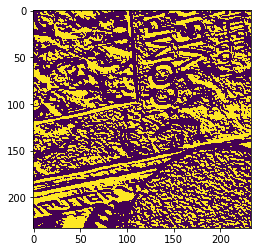

In [481]:
edges = G_magnitude > 0.55

# edges = np.zeros(G_magnitude.shape)*np.NaN #Create empty array of NaNs
# #Replace pixels with gradient estimates above thresh with the direction of the gradient estimate:
# edges[G_magnitude>1.00] = G_direction[G_magnitude>1.00]
G_something = G_direction > 0.9
# G_something1 = G_direction < 2
G_final = G_something #+ G_something
imshow(G_final)
# colorbar()

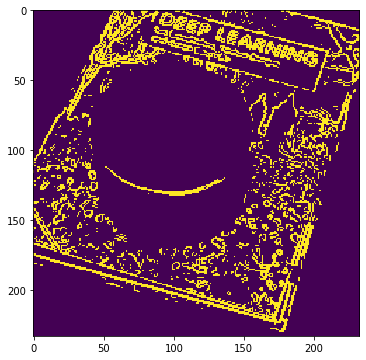

In [347]:
fig = figure(0, (6,6))
imshow(edges)

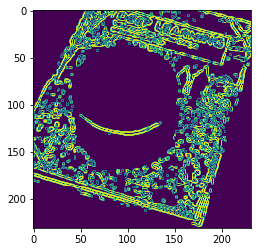

In [348]:
Kx = np.array([[1, 0, -1],
               [2, 0, -2],
               [1, 0, -1]])

Ky = np.array([[1, 2, 1],
               [0, 0, 0],
               [-1, -2, -1]])

#     gray = filter_2d(gray,gaussian_kernel)
edges_x = filter_2d(edges, Kx)
edges_y = filter_2d(edges, Ky)

#Compute Gradient Magnitude and Direction:
edges_magnitude= np.sqrt(edges_x**2 + edges_y**2)

        
# G_max = np.max(G_magnitude)
# #     G_mean = np.mean(G_magnitude)
imshow(edges_magnitude)
edges_ka_edges = edges_magnitude > (edges_magnitude > 0.6)

In [233]:
y_coords, x_coords = np.where(edges)

In [234]:
print(len(y_coords))


127


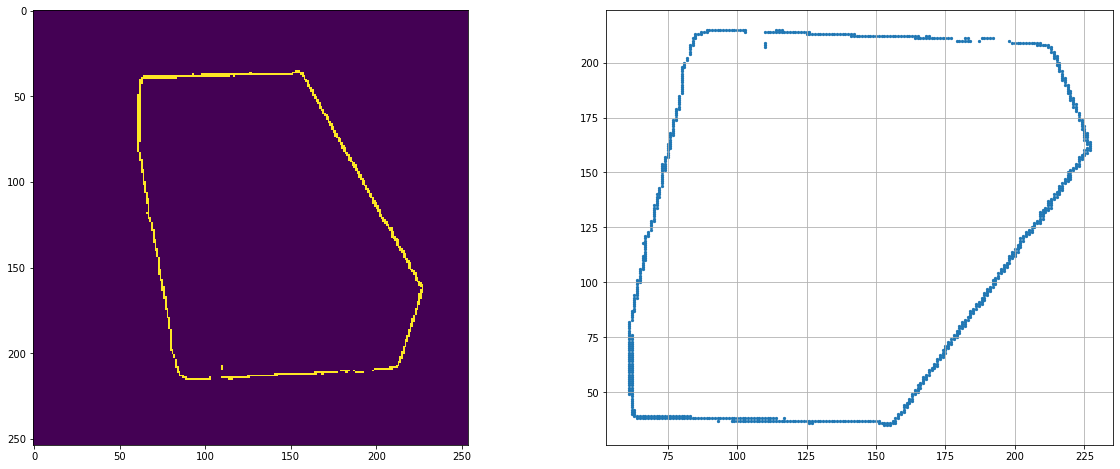

In [212]:
fig = figure(0, (20,8))
fig.add_subplot(1,2,1)
imshow(edges)

fig.add_subplot(1,2,2)
scatter(x_coords, y_coords, s = 5)
grid(1)


In [213]:
y_coords_flipped = edges.shape[0] - y_coords

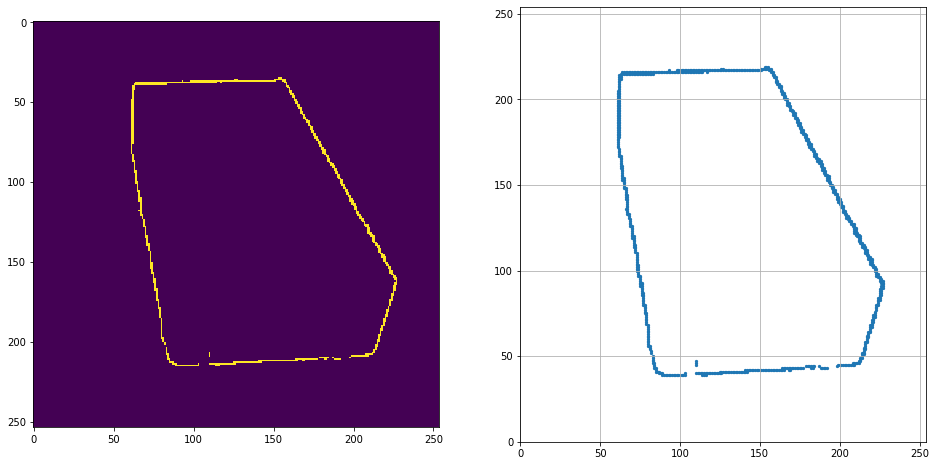

In [214]:
fig = figure(0, (16,8))
ax = fig.add_subplot(1,2,1)
imshow(edges)

ax2 = fig.add_subplot(1,2,2)
scatter(x_coords, y_coords_flipped, s = 5)
grid(1)
xlim([0, edges.shape[0]]);
ylim([0, edges.shape[0]]);

In [215]:
#How many bins for each variable in parameter space?
phi_bins = 128
theta_bins = 128

accumulator = np.zeros((phi_bins, theta_bins))

In [216]:
rho_min = -edges.shape[0]*np.sqrt(2)
rho_max = edges.shape[1]*np.sqrt(2)

theta_min = 0
theta_max = np.pi

#Compute the rho and theta values for the grids in our accumulator:
rhos = np.linspace(rho_min, rho_max, accumulator.shape[0])
thetas = np.linspace(theta_min, theta_max, accumulator.shape[1])

In [217]:
for i in range(len(x_coords)):
    #Grab a single point
    x = x_coords[i]
    y = y_coords_flipped[i]

    #Actually do transform!
    curve_rhos = x*np.cos(thetas)+y*np.sin(thetas)

    for j in range(len(thetas)):
        #Make sure that the part of the curve falls within our accumulator
        if np.min(abs(curve_rhos[j]-rhos)) <= 1.0:
            #Find the cell our curve goes through:
            rho_index = argmin(abs(curve_rhos[j]-rhos))
            accumulator[rho_index, j] += 1

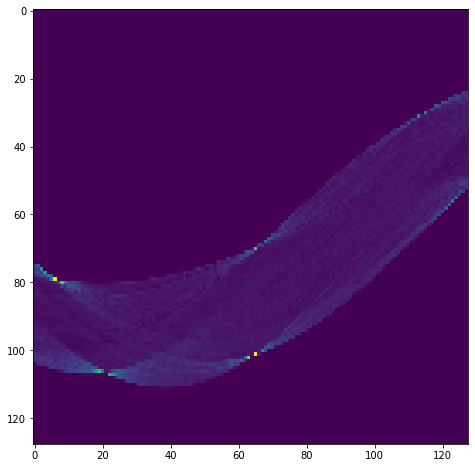

In [218]:
fig = figure(0, (8,8))
imshow(accumulator);

In [219]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = figure(figsize=(16, 16));
# ax1 = fig.add_subplot(111, projection='3d')

# _x = np.arange(accumulator.shape[0])
# _y = np.arange(accumulator.shape[1])
# _xx, _yy = np.meshgrid(_x, _y)
# x, y = _xx.ravel(), _yy.ravel()

# top = accumulator.ravel()
# bottom = np.zeros_like(top)
# width = depth = 1

# ax1.bar3d(x, y, bottom, width, depth, top, shade = True);

In [220]:
max_value = np.max(accumulator)

In [221]:
max_value


124.0

In [222]:
def tune_thresh(relative_thresh = 0.9):
    fig = figure(0, (8,8))
    imshow(accumulator > relative_thresh * max_value)

In [223]:
# interact(tune_thresh, relative_thresh = (0, 1, 0.05))

interactive(children=(FloatSlider(value=0.9, description='relative_thresh', max=1.0, step=0.05), Output()), _d…

<function __main__.tune_thresh(relative_thresh=0.9)>

In [224]:
relative_thresh = 0.4

#Indices of maximum theta and rho values
rho_max_indices, theta_max_indices,  = np.where(accumulator > relative_thresh * max_value)

In [225]:
theta_max_indices, rho_max_indices

(array([115, 113,  65,   2,   3,   4,   5,   6,   8,  67,  65,  63,  18,
         19,  20,  22,  23], dtype=int64),
 array([ 30,  31,  70,  76,  77,  78,  79,  79,  80, 100, 101, 102, 106,
        106, 106, 107, 107], dtype=int64))

In [226]:
len(theta_max_indices)

17

In [203]:
thetas_max = thetas[theta_max_indices]
rhos_max = rhos[rho_max_indices]

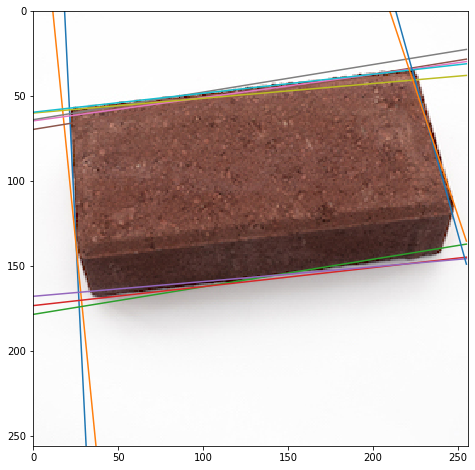

In [204]:
fig = figure(0, (8,8))
imshow(im)
 
for theta, rho in zip(thetas_max, rhos_max):
    #x-values to use in plotting:
    xs = np.arange(im.shape[1])
    
    #Check if theta == 0, this would be a vertical line
    if theta != 0:
        ys = -cos(theta)/sin(theta)*xs + rho/sin(theta)
        
    #Special handling for plotting vertical line:
    else:
        xs = rho*np.ones(len(xs))
        ys = np.arange(im.shape[0])
    
    #have to re-flip y-values to reverse the flip we applied initially:
    plot(xs, im.shape[0]-ys)
    
xlim([0, im.shape[0]]);
ylim([im.shape[1], 0]);